# Hyper parameters

In [108]:
INTERVALS_FUTURE = 50
INTERVALS_PAST = 50

HP_UNITS = 200
HP_LAYERS = 3

TRAIN_START = "2021-01-01"
TRAIN_END = "2021-10-01"

TEST_START = "2021-10-01"
TEST_END = "2021-11-01"

HP_DROPOUT = 0.5
HP_LR = 0.001
HP_BATCH_SIZE = 32  
HP_EPOCHS = 350

labels = ['next1', 'next2', 'next3']

SPREAD = 0.00008

INIT_DEPOSIT = 1000


In [109]:

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
%matplotlib inline



# Get Data

In [110]:
import quandl as q 

In [111]:
q.ApiConfig.api_key = '11sy5SMsFERx_YypjsMi'

In [112]:
data = q.get('BITFINEX/BTCUSD') 

In [113]:
import os
from binance.client import Client

client = Client('ECKmhCpRn2Wp3hL8J5ae6hIyXWl6nwMCInT8h4UI0dbUVeNngeyu9Zv7UAcOoBfs',
                '9pqP4wgHObK9W8WwUkT29zfTg8wZ1d84gAvnWwT8M6bHt4FY1ysFvNnTTMUZRh0P')

# get latest price from Binance API
btc_price = client.get_symbol_ticker(symbol="BTCUSDT")

# print full output (dictionary)
print(btc_price)


{'symbol': 'BTCUSDT', 'price': '63424.57000000'}


In [114]:
bars = client.get_historical_klines('BTCUSDT', '30m',  "2021-01-01", "2021-11-01")


In [115]:
from datetime import datetime

for line in bars:
    del line[2:]

data = pd.DataFrame(bars, columns=['Date', 'Last'])
data['Date'] = pd.to_datetime(data['Date'], unit='ms')
data['Last'] = pd.to_numeric(data['Last'])

data.set_index('Date', inplace=True)
data.to_csv('btc_bars30.csv')


In [116]:
data

,Last
Date,
2021-01-01 00:00:00,28923.63
2021-01-01 00:30:00,28836.63
2021-01-01 01:00:00,28995.13
2021-01-01 01:30:00,29387.07
2021-01-01 02:00:00,29410.00
...,...
2021-10-31 22:00:00,61444.34
2021-10-31 22:30:00,61485.77
2021-10-31 23:00:00,61365.72


<AxesSubplot:xlabel='Date'>

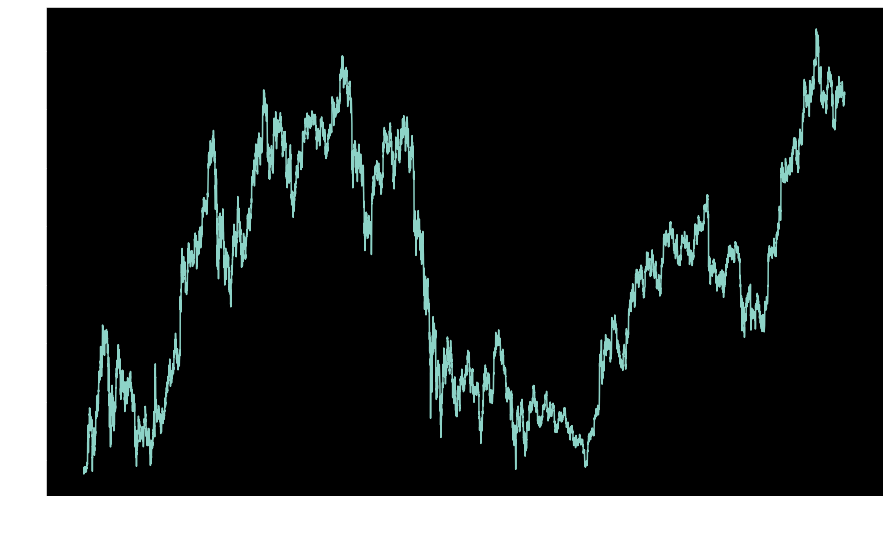

In [117]:
# show candles
data['Last'].plot(figsize=(15, 10))


# Create features

In [118]:
for i in range(1, INTERVALS_PAST):
    data['prev' + str(i)] = np.log(data['Last'] / data['Last'].shift(i))


In [119]:
for i in range(1, INTERVALS_FUTURE):
    data['next' + str(i)] = np.log(data['Last'] / data['Last'].shift(-i))


In [120]:
data.dropna(inplace=True)

In [121]:
data

,Last,prev1,prev2,prev3,prev4,prev5,prev6,prev7,prev8,prev9,...,next40,next41,next42,next43,next44,next45,next46,next47,next48,next49
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-02 00:30:00,29032.24,-0.010262,-0.008369,-0.007894,-0.008187,-0.004500,-0.006645,-0.005795,-0.006194,0.000110,...,-0.104622,-0.054859,-0.085230,-0.087706,-0.103544,-0.101804,-0.096158,-0.102828,-0.103559,-0.111230
2021-01-02 01:00:00,29197.93,0.005691,-0.004571,-0.002678,-0.002203,-0.002496,0.001191,-0.000954,-0.000104,-0.000503,...,-0.049169,-0.079540,-0.082015,-0.097853,-0.096113,-0.090467,-0.097137,-0.097868,-0.105539,-0.111030
2021-01-02 01:30:00,29208.45,0.000360,0.006051,-0.004211,-0.002318,-0.001843,-0.002136,0.001551,-0.000594,0.000256,...,-0.079179,-0.081655,-0.097493,-0.095753,-0.090107,-0.096777,-0.097508,-0.105179,-0.110670,-0.109334
2021-01-02 02:00:00,29359.46,0.005157,0.005517,0.011208,0.000946,0.002839,0.003314,0.003021,0.006708,0.004563,...,-0.076498,-0.092336,-0.090596,-0.084950,-0.091620,-0.092351,-0.100022,-0.105513,-0.104177,-0.110291
2021-01-02 02:30:00,29414.32,0.001867,0.007024,0.007384,0.013075,0.002813,0.004705,0.005181,0.004888,0.008575,...,-0.090469,-0.088730,-0.083084,-0.089753,-0.090485,-0.098156,-0.103646,-0.102310,-0.108424,-0.107167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-30 21:30:00,61525.44,-0.001894,-0.006779,-0.003333,-0.000790,-0.000576,0.001155,0.001868,0.002694,0.004382,...,0.010108,0.014918,0.017470,0.013414,0.012333,0.013673,0.009200,0.009850,0.005703,0.001319
2021-10-30 22:00:00,61429.02,-0.001568,-0.003463,-0.008348,-0.004901,-0.002358,-0.002145,-0.000414,0.000299,0.001126,...,0.013349,0.015902,0.011846,0.010765,0.012104,0.007631,0.008282,0.004135,-0.000249,-0.000923
2021-10-30 22:30:00,61396.92,-0.000523,-0.002091,-0.003985,-0.008870,-0.005424,-0.002881,-0.002667,-0.000936,-0.000223,...,0.015379,0.011323,0.010242,0.011582,0.007109,0.007759,0.003612,-0.000772,-0.001446,0.000508


# Model create

In [122]:
import tensorflow as tf


In [123]:
# create an MLP model
def create_model(input_shape, output_shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=HP_UNITS,
              activation='relu', input_shape=input_shape))
    for a in range(HP_LAYERS):
        model.add(tf.keras.layers.Dense(units=HP_UNITS, activation='relu'))
        if a != HP_LAYERS:
            model.add(tf.keras.layers.Dropout(HP_DROPOUT))

    model.add(tf.keras.layers.Dense(units=output_shape, activation='linear'))
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(
        HP_LR), metrics=["accuracy"])
    return model


# Split to train set and test set

In [124]:
X_train = data.loc[(data.index >= TRAIN_START) &
                   (data.index <= TRAIN_END)]
X_test = data.loc[(data.index >= TEST_START) &
                  (data.index <= TEST_END)]


In [125]:

y_train = X_train[labels].to_numpy()  # X - source, y - target
y_test = X_test[labels].to_numpy()


In [126]:
columns = []
for i in range(1, INTERVALS_PAST):
    columns.append('prev' + str(i))


In [127]:
X_train = X_train[columns].to_numpy()
X_test_times = X_test.index
X_test_price = X_test['Last'].to_numpy()
X_test = X_test[columns].to_numpy()


In [128]:
train_ds = tf.data.Dataset.from_tensor_slices(((X_train), y_train))
train_ds = train_ds.take(len(X_train))
test_ds = tf.data.Dataset.from_tensor_slices(((X_test), y_test))
test_ds = test_ds.take(len(X_test))
train_ds = train_ds.batch(HP_BATCH_SIZE, False).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(len(X_test), False).prefetch(tf.data.AUTOTUNE)


In [129]:
X_train.shape

(13025, 49)

In [130]:
X_test.shape

(1440, 49)

In [131]:
model = create_model(X_test[0].shape, len(y_test[0]))


# Training model

In [132]:
callback_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=50)


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=HP_BATCH_SIZE,
    # callbacks=[callback_early],
    verbose=2, epochs=HP_EPOCHS)


Epoch 1/350
408/408 - 2s - loss: 1.0804e-04 - accuracy: 0.3479 - val_loss: 4.7914e-05 - val_accuracy: 0.3556
Epoch 2/350
408/408 - 1s - loss: 1.0255e-04 - accuracy: 0.3405 - val_loss: 4.5554e-05 - val_accuracy: 0.3778
Epoch 3/350
408/408 - 1s - loss: 1.0250e-04 - accuracy: 0.3400 - val_loss: 4.6043e-05 - val_accuracy: 0.3778
Epoch 4/350
408/408 - 1s - loss: 1.0232e-04 - accuracy: 0.3483 - val_loss: 4.8771e-05 - val_accuracy: 0.3556
Epoch 5/350
408/408 - 2s - loss: 1.0239e-04 - accuracy: 0.3387 - val_loss: 4.5882e-05 - val_accuracy: 0.3778
Epoch 6/350
408/408 - 2s - loss: 1.0281e-04 - accuracy: 0.3460 - val_loss: 4.7067e-05 - val_accuracy: 0.3556
Epoch 7/350
408/408 - 1s - loss: 1.0290e-04 - accuracy: 0.3390 - val_loss: 4.6541e-05 - val_accuracy: 0.2667
Epoch 8/350
408/408 - 1s - loss: 1.0268e-04 - accuracy: 0.3364 - val_loss: 4.5976e-05 - val_accuracy: 0.3556
Epoch 9/350
408/408 - 1s - loss: 1.0235e-04 - accuracy: 0.3388 - val_loss: 4.7240e-05 - val_accuracy: 0.3556
Epoch 10/350
408/40

In [133]:
# helper functions to plot accuracy and loss
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [134]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


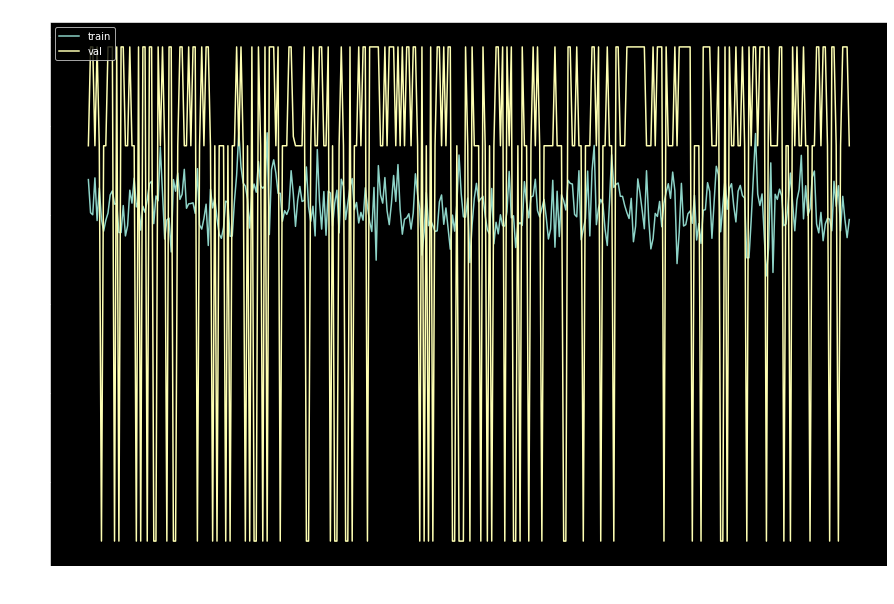

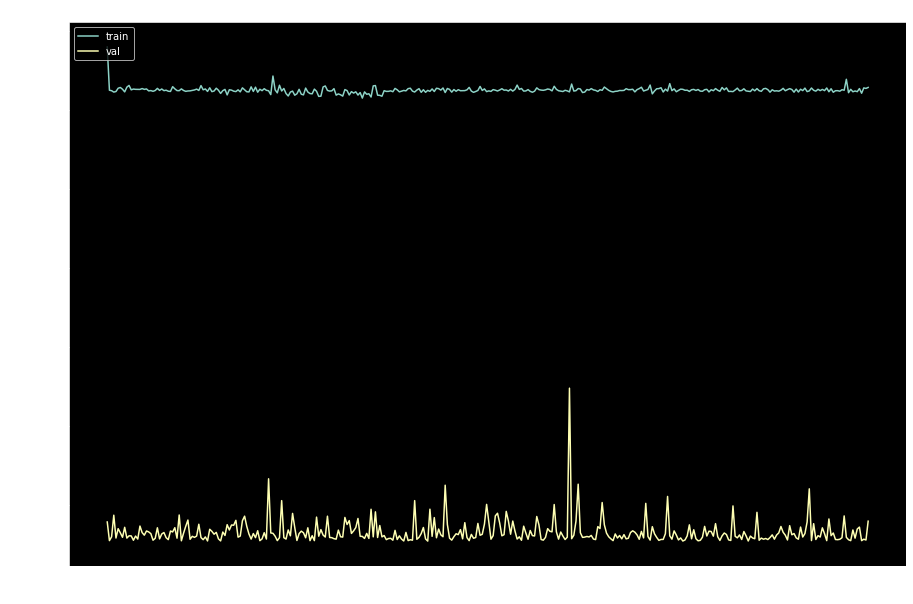

In [135]:
plt.figure(figsize=(15, 10))
plot_accuracy(history)
plt.figure(figsize=(15, 10))
plot_loss(history)


# Trains results

In [136]:
train_prediction = model.predict(X_train)


In [137]:

from sklearn.metrics import mean_absolute_error

train_mse = mean_absolute_error(y_train, train_prediction)
round(train_mse, 5)


0.00669

In [138]:
for i in range(len(labels)):
    print (labels[i],   "{:8.5f}".format(mean_absolute_error(y_train[:,i], train_prediction[:,i])))  

next1  0.00480
next2  0.00679
next3  0.00847


In [139]:
best = 0

for j in range(len(labels)):
    c = 0
    n = 0
    for i in range(len(y_train)):
        if abs(train_prediction[i, j]) < 0.00001:
            continue
        n = n+1
        if (np.sign(y_train[i, j]) == np.sign(train_prediction[i, j])):
            c = c+1
    print(labels[j], round(c/n, 3))
    if c/n > best:
        best = c/n
        best_label = j

labels[best_label]


next1 0.49
next2 0.487
next3 0.487


'next1'

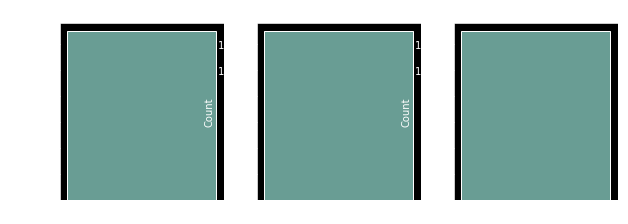

In [140]:
import seaborn as sns

fig = plt.figure(figsize=(10,15))

for i in range(min(len(labels),12)):
    fig.add_subplot(4, 3, i+1)
    plt.title(labels[i])
    sns.histplot(data=train_prediction[:, i])


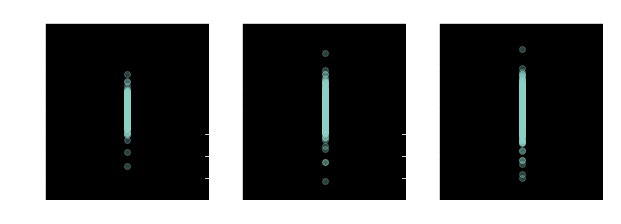

In [141]:
fig = plt.figure(figsize=(10,15))

for i in range(min(len(labels),12)):
    fig.add_subplot(4, 3, i+1)
    plt.title(labels[i])

    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.2, 0.2)
    plt.scatter(train_prediction[:, i], y_train[:, i], alpha=0.3)


# Test results

In [142]:
test_prediction=model.predict(X_test)

In [143]:
from sklearn.metrics import mean_absolute_error

test_mse = mean_absolute_error(y_test, test_prediction)
round(train_mse,5)

0.00669

In [144]:
for i in range(len(labels)):
    print (labels[i],   "{:8.5f}".format(mean_absolute_error(y_test[:,i], test_prediction[:,i])))  

next1  0.00342
next2  0.00479
next3  0.00590


In [145]:
best = 0

for j in range(len(labels)):
    c = 0
    n = 0
    for i in range(len(y_test)):
        if abs(test_prediction[i, j]) < 0.00001:
            continue
        n = n+1
        if (np.sign(y_test[i, j]) == np.sign(test_prediction[i, j])):
            c = c+1
    print(labels[j], round(c/n, 3))
    if c/n > best:
        best = c/n
        best_label = j

labels[best_label]


next1 0.492
next2 0.496
next3 0.489


'next2'

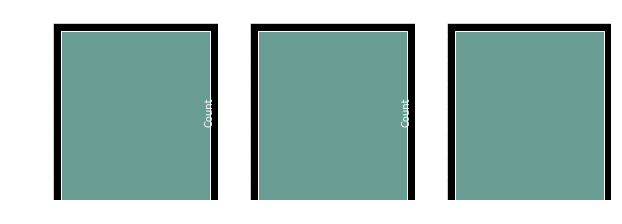

In [146]:
import seaborn as sns

fig = plt.figure(figsize=(10,15))

for i in range(min(len(labels),12)):
    fig.add_subplot(4, 3, i+1)
    plt.title(labels[i])
    sns.histplot(data=test_prediction[:, i])


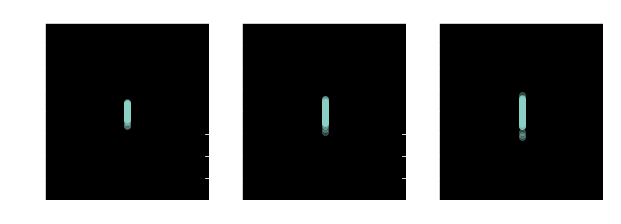

In [147]:
fig = plt.figure(figsize=(10,15))

for i in range(min(len(labels),12)):
    fig.add_subplot(4, 3, i+1)
    plt.title(labels[i])
    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.2, 0.2)
    plt.scatter(test_prediction[:, i], y_test[:, i], alpha=0.3)


# Backtesting

In [148]:
summer = lambda y: sum(y)/len(labels)
test_sum = np.array([summer(y) for y in test_prediction])


In [149]:
data = pd.DataFrame({'Datetime': X_test_times, 'distance': test_sum, 'Last': X_test_price })


In [150]:
def run_strategy(a_data, threshold):
    ''' Backtests the trading strategy.
    '''
    data = a_data.copy().dropna()
    data['returns'] = np.log(data['Last'] / data['Last'].shift(1)).dropna()
    # buy BTC signals
    data['position'] = np.where(data['distance'] > threshold, 1, np.nan)
    # sell BTC signals
    data['position'] = np.where(data['distance'] < -threshold, -1,
                                data['position'])
    data['position'] = data['position'].ffill().fillna(0)
    data['strategy'] = data['position'].shift(1) * data['returns']
    # determine when a trade takes place
    trades = data['position'].diff().fillna(0) != 0
    # subtract transaction costs from return when trade takes place
    data['strategy'][trades] -= SPREAD
    data['buy'] = data['position'].diff().fillna(0) > 0
    data['sell'] = data['position'].diff().fillna(0) < 0
    data['creturns'] = INIT_DEPOSIT * data['returns'].cumsum().apply(np.exp)
    data['cstrategy'] = INIT_DEPOSIT * data['strategy'].cumsum().apply(np.exp)
    results = data
    # absolute performance of the strategy
    aperf = results['cstrategy'].iloc[-1]
    # base instrument performance (BTC)
    bperf = results['creturns'].iloc[-1]
    # out-/underperformance of strategy
    operf = aperf - bperf

    return round(aperf, 2), round(operf, 2), results


In [153]:
pd.set_option('mode.chained_assignment', None)
best_threshold = 0
best_aperf = 0
for i in range(100):
    x, y, z = run_strategy(data, i/100)
    print(i/100, x)
    if x > best_aperf:
        best_aperf = x
        best_threshold = i/100


0.0 1406.62
0.01 1000.0
0.02 1000.0
0.03 1000.0
0.04 1000.0
0.05 1000.0
0.06 1000.0
0.07 1000.0
0.08 1000.0
0.09 1000.0
0.1 1000.0
0.11 1000.0
0.12 1000.0
0.13 1000.0
0.14 1000.0
0.15 1000.0
0.16 1000.0
0.17 1000.0
0.18 1000.0
0.19 1000.0
0.2 1000.0
0.21 1000.0
0.22 1000.0
0.23 1000.0
0.24 1000.0
0.25 1000.0
0.26 1000.0
0.27 1000.0
0.28 1000.0
0.29 1000.0
0.3 1000.0
0.31 1000.0
0.32 1000.0
0.33 1000.0
0.34 1000.0
0.35 1000.0
0.36 1000.0
0.37 1000.0
0.38 1000.0
0.39 1000.0
0.4 1000.0
0.41 1000.0
0.42 1000.0
0.43 1000.0
0.44 1000.0
0.45 1000.0
0.46 1000.0
0.47 1000.0
0.48 1000.0
0.49 1000.0
0.5 1000.0
0.51 1000.0
0.52 1000.0
0.53 1000.0
0.54 1000.0
0.55 1000.0
0.56 1000.0
0.57 1000.0
0.58 1000.0
0.59 1000.0
0.6 1000.0
0.61 1000.0
0.62 1000.0
0.63 1000.0
0.64 1000.0
0.65 1000.0
0.66 1000.0
0.67 1000.0
0.68 1000.0
0.69 1000.0
0.7 1000.0
0.71 1000.0
0.72 1000.0
0.73 1000.0
0.74 1000.0
0.75 1000.0
0.76 1000.0
0.77 1000.0
0.78 1000.0
0.79 1000.0
0.8 1000.0
0.81 1000.0
0.82 1000.0
0.83 1000.0


In [154]:
run_strategy(data, best_threshold)


(1406.62,
 0.0,
                 Datetime  distance      Last   returns  position  strategy  \
 0    2021-10-01 00:00:00  0.000947  43820.01       NaN       1.0       NaN   
 1    2021-10-01 00:30:00  0.000947  43872.99  0.001208       1.0  0.001208   
 2    2021-10-01 01:00:00  0.000947  43696.14 -0.004039       1.0 -0.004039   
 3    2021-10-01 01:30:00  0.000947  43609.43 -0.001986       1.0 -0.001986   
 4    2021-10-01 02:00:00  0.000947  43742.74  0.003052       1.0  0.003052   
 ...                  ...       ...       ...       ...       ...       ...   
 1435 2021-10-30 21:30:00  0.000947  61525.44 -0.001894       1.0 -0.001894   
 1436 2021-10-30 22:00:00  0.000947  61429.02 -0.001568       1.0 -0.001568   
 1437 2021-10-30 22:30:00  0.000947  61396.92 -0.000523       1.0 -0.000523   
 1438 2021-10-30 23:00:00  0.000947  61540.32  0.002333       1.0  0.002333   
 1439 2021-10-30 23:30:00  0.000947  61637.99  0.001586       1.0  0.001586   
 
         buy   sell     creturns  